In [1]:
import random
import numpy as np
import sys 
import csv
from scipy import stats
sys.path.append('..')
import math

from prior import prior
from liklihood import liklihood
from posterior import posterior
import graph_image_generator
import utilities
import matplotlib.pyplot as plt
from matplotlib import rc
import pylab as pl

In [2]:
# Create an artifical set of observations
no_of_observations = 100
min_graph_size = [1,1] # This is read as the minimum number of pos arguments is 1 and the maximum is 1
max_graph_size = [3,3] 

## Measuring Diversion 

We first need to define what it means to add noise to probability distribution. We know that the distributions differ primarily in terms of rating. A perfectly coherent distribution is thus one which is conforms to the distribution. i.e one in which the dataset is distributed according to the prior.


In [3]:
target_distribution = {}
target_distribution['pos_args'] = ['a','b']
target_distribution['neg_args'] = ['c']
target_distribution['rating'] = 10

p_G = prior(target_distribution['pos_args'], target_distribution['neg_args'])

# generate the prior distribution
target_prior_distribution = p_G.getDistribution(target_distribution['rating'])

In [4]:
# Generate the dataset
# Start with the matching rating and matching graph space and closest distribution

In [5]:
dataset_rating = target_distribution['rating']
graph_space_pos_args  = target_distribution['pos_args']
graph_space_neg_args = target_distribution['neg_args']

In [6]:
observations = []

for graph in p_G.arg_matrices:
    observation = {}
    observation['pos_args'] = target_distribution['pos_args']
    observation['neg_args'] = target_distribution['neg_args']
    observation['rating'] = target_distribution['rating']
    observation['attacks'] = utilities.convertArgMtrxToAttacks(observation['pos_args'], 
                                                               observation['neg_args'],
                                                              graph)
    
    observations.append(observation)
    



In [7]:
target_quantities = (np.array(target_prior_distribution) * 100).astype(int)

In [8]:
synthetic_dataset = []
for idx, observation in enumerate(observations):
    synthetic_dataset.extend([observation]*1)

In [9]:
# Now construct posterior iteratively 
p_G.rating = 10
all_updates_distribution = []

current_prior = target_prior_distribution

for synthetic_observation in synthetic_dataset:

    p_G_T = liklihood(p_G, synthetic_observation)
    liklihood_distribution = p_G_T.buildLiklihoodDistribution()
    
    p_T_G = posterior(current_prior, liklihood_distribution)
    posterior_distribution = p_T_G.buildPosteriorDistribution()
    
    all_updates_distribution.append(posterior_distribution)
    
    current_prior = posterior_distribution

In [10]:
current_prior

array([1.81733059e-02, 1.83611377e-01, 1.83611377e-01, 1.78047396e-01,
       1.78047396e-01, 2.85011905e-02, 2.85011905e-02, 5.98521985e-02,
       5.98521985e-02, 4.28629026e-02, 2.82331416e-02, 3.60539600e-03,
       3.60539600e-03, 1.70922477e-03, 1.70922477e-03, 7.70854335e-05])

In [11]:
target_prior_distribution

[0.17456667587415306,
 0.1304827511724852,
 0.1304827511724852,
 0.1304827511724852,
 0.1304827511724852,
 0.06284960246164265,
 0.06284960246164265,
 0.03281924786371375,
 0.03281924786371375,
 0.03281924786371375,
 0.019477753708987976,
 0.012735106952699542,
 0.012735106952699542,
 0.012735106952699542,
 0.012735106952699542,
 0.008927189401693526]

# Attacks that are always true

In [12]:
# Want to know what we are checking for. Want to check that some long standing patterns are captured. So if a particular
# graph structure always holds true as well as the extension holding true.
always_true = [[('a','c')]]

In [13]:
def check_attack_holds(pos_args, neg_args, always_true, graph):
    
    all_args = pos_args + neg_args
    appropriate_graph = []
    
    for t in always_true:
        
        if t[0][0] not in all_args or t[0][1] not in all_args:
            appropriate_graph.append(False)
            continue
            
        attacker = all_args.index(t[0][0])
        attacked = all_args.index(t[0][1])
        
        if len(t) == 1:
            if graph[attacker, attacked] == 1 and graph[attacked, attacker] == 0:
                appropriate_graph.append(True)
            else:
                appropriate_graph.append(False)
            continue
            
        if len(t) == 2:
            if graph[attacker, attacked] == 1 and graph[attacked, attacker] == 1:
                appropriate_graph.append(True)
            else:
                appropriate_graph.append(False)
            continue
            
    return all(appropriate_graph)

In [14]:
p_G_2args = prior(['a'], ['c'])
p_G_2args_prior_distribution =  p_G_2args.getDistribution(target_distribution['rating'])

p_G_3args = prior(['a','b'], ['c'])
p_G_3args_prior_distribution =  p_G_3args.getDistribution(target_distribution['rating'])

p_G_3args_2 = prior(['a','d'], ['c'])
p_G_3args_2_prior_distribution =  p_G_3args_2.getDistribution(target_distribution['rating'])

p_G_4args = prior(['a','d','b'], ['c'])
p_G_4args_prior_distribution =  p_G_4args.getDistribution(target_distribution['rating'])

In [15]:
target_no_observations = 100

all_p_g = [p_G_2args, p_G_3args, p_G_3args_2, p_G_4args]
all_prior_distribs = [p_G_2args_prior_distribution, 
                     p_G_3args_prior_distribution,
                     p_G_3args_2_prior_distribution,
                     p_G_4args_prior_distribution]
index_p_G_s = list(range(len(all_p_g)))

In [16]:
index_p_G_s

[0, 1, 2, 3]

In [17]:
observations = []

while len(observations) <=100:
    choice = random.choice(index_p_G_s)
    chosen_prior = all_prior_distribs[choice]
    
    possible_graphs = []
    possible_graphs_probabilities = []
    for graph_no, graph in enumerate((all_p_g[choice]).arg_matrices):
        if check_attack_holds(all_p_g[choice].pos_args, all_p_g[choice].neg_args, always_true, graph):            
            possible_graphs.append(graph)
            possible_graphs_probabilities.append(chosen_prior[graph_no])
        
    
    possible_graphs_probabilities = possible_graphs_probabilities / np.sum(possible_graphs_probabilities)
    
    indices = list(range(len(possible_graphs_probabilities)))
    custm = stats.rv_discrete(name='custm', values=(indices, possible_graphs_probabilities))
    chosen_graph = custm.rvs(size=1)[0]
    
    
    observation = {}
    observation['pos_args'] = all_p_g[choice].pos_args
    observation['neg_args'] = all_p_g[choice].neg_args
    observation['attacks'] = utilities.convertArgMtrxToAttacks(observation['pos_args'], 
                                                               observation['neg_args'],
                                                              possible_graphs[chosen_graph])
    
    observation['rating'] = 10
    observations.append(observation)

# 3 arg target distribution

In [18]:
target_distribution = {}
target_distribution['pos_args'] = ['a','b']
target_distribution['neg_args'] = ['c']
target_distribution['rating'] = 10

p_G = prior(target_distribution['pos_args'], target_distribution['neg_args'])

# generate the prior distribution
target_prior_distribution = p_G.getDistribution(target_distribution['rating'])

p_G.rating = 10
all_updates_distribution = []

current_prior = target_prior_distribution

for synthetic_observation in observations:

    p_G_T = liklihood(p_G, synthetic_observation)
    liklihood_distribution = p_G_T.buildLiklihoodDistribution()
    
    p_T_G = posterior(current_prior, liklihood_distribution)
    posterior_distribution = p_T_G.buildPosteriorDistribution()
    
    all_updates_distribution.append(posterior_distribution)
    
    current_prior = posterior_distribution

In [19]:
# plot a bar chart

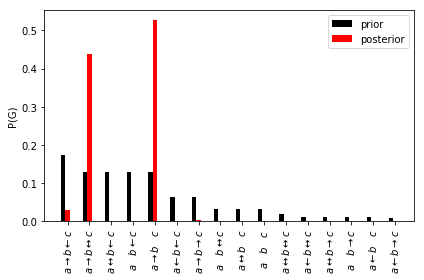

In [20]:
b1 = target_prior_distribution
b2 = current_prior
x = np.array(list(range(16)))
fig = plt.figure()
plt.bar(left=x-0.2, width=0.2, height=b1 ,color='k', label='prior')
plt.bar(left=x, width=0.2, height=b2, color='r', label = 'posterior')
plt.xticks(list(range(16)),
           [r'$a \rightarrow b \leftarrow c$',
           r'$a \rightarrow b \leftrightarrow c$',
           r'$a \leftrightarrow b \leftarrow c$',
           r'$a \quad b \leftarrow c$',
           r'$a \rightarrow b \quad c$',
           r'$a \leftarrow b \leftarrow c$',
           r'$a \rightarrow b \rightarrow c$',
           r'$a \quad b \leftrightarrow c$',
           r'$a \leftrightarrow b \quad c$',
           r'$a \quad b \quad c$',
           r'$a \leftrightarrow b \leftrightarrow c$',
           r'$a \leftarrow b \leftrightarrow c$',
           r'$a \leftrightarrow b \rightarrow c$',
           r'$a \quad b \rightarrow c$',
           r'$a \leftarrow b \quad c$',
           r'$a \leftarrow b \rightarrow c$'], rotation='vertical')

plt.ylabel('P(G)')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('3_arg_full_consistent.png')

In [21]:
target_distribution = {}
target_distribution['pos_args'] = ['a']
target_distribution['neg_args'] = ['c']
target_distribution['rating'] = 10

p_G = prior(target_distribution['pos_args'], target_distribution['neg_args'])

# generate the prior distribution
target_prior_distribution = p_G.getDistribution(target_distribution['rating'])

p_G.rating = 10
all_updates_distribution = []

current_prior = target_prior_distribution

for synthetic_observation in observations:

    p_G_T = liklihood(p_G, synthetic_observation)
    liklihood_distribution = p_G_T.buildLiklihoodDistribution()
    
    p_T_G = posterior(current_prior, liklihood_distribution)
    posterior_distribution = p_T_G.buildPosteriorDistribution()
    
    all_updates_distribution.append(posterior_distribution)
    
    current_prior = posterior_distribution

In [22]:
current_prior

array([1.00000000e+00, 2.72452508e-21, 2.72452508e-21, 1.18218297e-51])

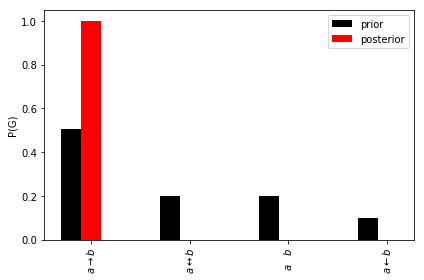

In [23]:
b1 = target_prior_distribution
b2 = current_prior
x = np.array(list(range(4)))
fig = plt.figure()
plt.bar(left=x-0.2, width=0.2, height=b1 ,color='k', label='prior')
plt.bar(left=x, width=0.2, height=b2, color='r', label = 'posterior')
plt.xticks(list(range(4)),
           [r'$a \rightarrow b$',
           r'$a \leftrightarrow b$',
           r'$a \quad b$',
           r'$a \leftarrow b$'], rotation='vertical')

plt.ylabel('P(G)')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('2_arg_full_consistent.png')

# Run experiment and see how well we capture attacks which appear with varying degrees of 

In [24]:
always_true = [[('a','c')],[('c', 'b')]]
degree_of_appearance = [0.6] # means it appears 60 % of the time

In [25]:
def generateSyntheticObservations(target_no_observations, all_p_g, all_prior_distribs, degree_of_appearance, always_true):

    observations = []
    index_p_G_s = list(range(len(all_p_g)))

    while len(observations) < target_no_observations:
        choice = random.choice(index_p_G_s) # choose an index from the list, index corresponds to one of the graph spaces
        chosen_prior = all_prior_distribs[choice] # store the prior for the graph space


        possible_graphs = []
        possible_graphs_probabilities = []

        appear_draw = random.uniform(0, 1)
        if appear_draw <= degree_of_appearance:
            for graph_no, graph in enumerate((all_p_g[choice]).arg_matrices):
                result = check_attack_holds(all_p_g[choice].pos_args, all_p_g[choice].neg_args, always_true, graph)
                if result:            
                    possible_graphs.append(graph)
                    possible_graphs_probabilities.append(chosen_prior[graph_no])

            if len(possible_graphs) ==0:
                continue
            possible_graphs_probabilities = possible_graphs_probabilities / np.sum(possible_graphs_probabilities)

        else:
            possible_graphs = (all_p_g[choice]).arg_matrices
            possible_graphs_probabilities = chosen_prior


        indices = list(range(len(possible_graphs_probabilities)))
        custm = stats.rv_discrete(name='custm', values=(indices, possible_graphs_probabilities))
        chosen_graph = custm.rvs(size=1)[0]

        observation = {}
        observation['pos_args'] = all_p_g[choice].pos_args
        observation['neg_args'] = all_p_g[choice].neg_args
        observation['attacks'] = utilities.convertArgMtrxToAttacks(observation['pos_args'], 
                                                                   observation['neg_args'],
                                                                  possible_graphs[chosen_graph])

        observation['rating'] = 10

        observations.append(observation)
        

    return observations
    

In [26]:
observations = generateSyntheticObservations(50, all_p_g, all_prior_distribs, 0.6, always_true)

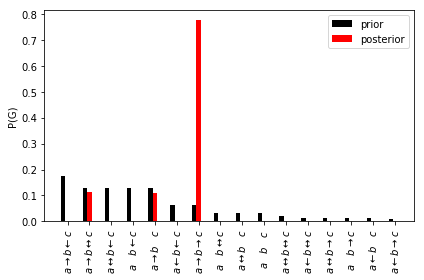

In [27]:
target_distribution = {}
target_distribution['pos_args'] = ['a','b']
target_distribution['neg_args'] = ['c']
target_distribution['rating'] = 10

p_G = prior(target_distribution['pos_args'], target_distribution['neg_args'])

# generate the prior distribution
target_prior_distribution = p_G.getDistribution(target_distribution['rating'])

p_G.rating = 10
all_updates_distribution = []

current_prior = target_prior_distribution

for synthetic_observation in observations[0:50]:

    p_G_T = liklihood(p_G, synthetic_observation)
    liklihood_distribution = p_G_T.buildLiklihoodDistribution()
    
    p_T_G = posterior(current_prior, liklihood_distribution)
    posterior_distribution = p_T_G.buildPosteriorDistribution()
    
    all_updates_distribution.append(posterior_distribution)
    
    current_prior = posterior_distribution
    
    
b1 = target_prior_distribution
b2 = current_prior
x = np.array(list(range(16)))
fig = plt.figure()
plt.bar(left=x-0.2, width=0.2, height=b1 ,color='k', label='prior')
plt.bar(left=x, width=0.2, height=b2, color='r', label = 'posterior')
plt.xticks(list(range(16)),
           [r'$a \rightarrow b \leftarrow c$',
           r'$a \rightarrow b \leftrightarrow c$',
           r'$a \leftrightarrow b \leftarrow c$',
           r'$a \quad b \leftarrow c$',
           r'$a \rightarrow b \quad c$',
           r'$a \leftarrow b \leftarrow c$',
           r'$a \rightarrow b \rightarrow c$',
           r'$a \quad b \leftrightarrow c$',
           r'$a \leftrightarrow b \quad c$',
           r'$a \quad b \quad c$',
           r'$a \leftrightarrow b \leftrightarrow c$',
           r'$a \leftarrow b \leftrightarrow c$',
           r'$a \leftrightarrow b \rightarrow c$',
           r'$a \quad b \rightarrow c$',
           r'$a \leftarrow b \quad c$',
           r'$a \leftarrow b \rightarrow c$'], rotation='vertical')

plt.ylabel('P(G)')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('3_arg_full_consistent_6.png')

In [28]:
graph_probabilities = []

appearance = 0.8
for i in range(1000):
    print(i)
    observations = generateSyntheticObservations(50, all_p_g, all_prior_distribs, appearance, always_true)
    
    
    target_distribution = {}
    target_distribution['pos_args'] = ['a','b']
    target_distribution['neg_args'] = ['c']
    target_distribution['rating'] = 10

    p_G = prior(target_distribution['pos_args'], target_distribution['neg_args'])

    # generate the prior distribution
    target_prior_distribution = p_G.getDistribution(target_distribution['rating'])

    p_G.rating = 10
    all_updates_distribution = []

    current_prior = target_prior_distribution

    for synthetic_observation in observations:

        p_G_T = liklihood(p_G, synthetic_observation)
        liklihood_distribution = p_G_T.buildLiklihoodDistribution()

        p_T_G = posterior(current_prior, liklihood_distribution)
        posterior_distribution = p_T_G.buildPosteriorDistribution()

        all_updates_distribution.append(posterior_distribution)

        current_prior = posterior_distribution

    graph_probabilities.append(current_prior[6])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
graph_probabilities

[0.9083687786122159,
 0.9810447706936467,
 0.905047920368371,
 0.9926706090133842,
 0.7838510475780793,
 0.9935483884677829,
 0.9936674712033499,
 0.9917159633203674,
 0.9880511287261848,
 0.9878407384688047,
 0.962335871265137,
 0.9824883160970802,
 0.9715448575659023,
 0.9686067558343194,
 0.9318657610506496,
 0.756792322168388,
 0.9458395159699139,
 0.9543021899793078,
 0.9873285730651621,
 0.9226007430852966,
 0.9711003915775696,
 0.9002732966782752,
 0.7856271798300457,
 0.9773066926221239,
 0.9850465609883804,
 0.9886480845848257,
 0.9640581458924978,
 0.969343051305382,
 0.9802198073061841,
 0.9911676426603797,
 0.9281366593637025,
 0.9312568096565487,
 0.8299051923155298,
 0.9795669597865743,
 0.9919202448613816,
 0.9675195351118351,
 0.7880387854042332,
 0.9831639246727253,
 0.9828696026284969,
 0.8528261776657621,
 0.8848375405329322,
 0.9366673982716827,
 0.9804733249590114,
 0.9327262720353864,
 0.9627405088054927,
 0.9065424302489337,
 0.9470479240110261,
 0.97831149372502

In [30]:

h = sorted(graph_probabilities_dict[4])  #sorted


fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed


plt.plot(h,fit)
      #use this to draw histogram of your data

plt.hist(h,normed=True) 
    
plt.show()


NameError: name 'graph_probabilities_dict' is not defined

In [ ]:
fit.cumsum()[900]

In [ ]:
stats.norm(0, 1)

In [ ]:
scipy.stats.norm(0, 1).pdf(0)

In [ ]:
h = sorted(graph_probabilities_dict[0])  #sorted

fig = plt.figure()

plt.xlabel('P(G)')

for key, item in graph_probabilities_dict.items():
    if key == 0:
        continue
    h = sorted(item)

    fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

    noise_level = round(1 - key/10, 1)
    
    plt.plot(h,fit, label='noise='+ str(noise_level))
      #use this to draw histogram of your data
    plt.legend()
plt.show()
fig.savefig('all_simulations_noise.jpeg')

In [31]:
graph_probabilities_dict = {}

In [ ]:
graph_probabilities_dict[8] = graph_probabilities

In [ ]:
import json

with open('simulations.json', 'w') as fp:
    json.dump(graph_probabilities_dict, fp)

In [ ]:
with open('simulations.json', 'r') as fp:
    data = json.load(fp)

# Diagrams for Paper 1

In [ ]:
agg_distances = np.array([0,
                1,
                0,
                0,
                0,
                1,
                0,
                0,
                1,
                1,
                0,
                1,
                0,
                1,
                1,
                1,
                1,
                0,
                2,
                1,
                0,
                0,
                4,
                0,
                1,
                4,
                0,
                3,
                2])

probabilities = np.array([0,
                          2,
                          0,
                          0,
                          0,
                          16,
                          0,
                          0,
                          3,
                          13,
                          0,
                          8,
                          0,
                          8,
                          20,
                          7,
                          7,
                          0,
                          10,
                          2,
                          0,
                          0,
                          1,
                          0,
                          1,
                          4,
                          0,
                          1,
                          0])

probabilities = probabilities/100

In [ ]:
hamms = [1,
        0,
        0,
        0,
        1,]

In [ ]:
len(probabilities)

In [ ]:
x = np.array(list(range(len(agg_distances))))
s1 = np.sin(2 * np.pi * t)
s2 = np.exp(-t)
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 3))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.1)

# Plot each graph, and manually set the y tick values
axs[0].bar(left=x,height=agg_distances, width=0.3, label=r'$|\mathsf{Agg}(G) - \mathsf{Agg}(\hat{G})| \times \frac{1}{\Delta Att}$')
axs[0].legend(loc="upper left")

axs[1].bar(left=x,height=probabilities, width=0.3, color='r' ,label=r'$|P(G)-P(\hat{G})|$')
axs[1].legend(loc="upper left")

plt.xticks(x)
plt.show()

fig.savefig('experiment_summary.png')